In [ ]:
!pip install  datasets transformers
!pip install accelerate nvidia-ml-py3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=18f1d11feb90adaabca023eadaaf728a2f672437da33ef07ef3f9052deff5c5b
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [ ]:
 import numpy as np
 from datasets import Dataset
 seq_len, dataset_size = 512, 512
dummy_data = {
    "input_ids": np.random.randint(100, 30000, (dataset_size, seq_len)),
    "labels": np.random.randint(0, 1, (dataset_size)),
}

In [ ]:
dummy_data

In [ ]:
ds = Dataset.from_dict(dummy_data)
ds.set_format("pt")

In [ ]:
ds#['features']

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 512
})

In [ ]:
from pynvml import *

In [ ]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
print_gpu_utilization()

GPU memory occupied: 258 MB.


In [ ]:
import torch
torch.ones((1, 1)).to("cuda")
print_gpu_utilization()

GPU memory occupied: 363 MB.


In [ ]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased").to("cuda")
print_gpu_utilization()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU memory occupied: 1651 MB.


In [ ]:
!nvidia-smi

Wed Sep 27 07:35:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |   1393MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [ ]:
from transformers import TrainingArguments, Trainer, logging

logging.set_verbosity_error()


training_args = TrainingArguments(per_device_train_batch_size=4, **default_args)
trainer = Trainer(model=model, args=training_args, train_dataset=ds)
result = trainer.train()
print_summary(result)

{'train_runtime': 178.2484, 'train_samples_per_second': 2.872, 'train_steps_per_second': 0.718, 'train_loss': 6.134124851087108e-05, 'epoch': 1.0}
Time: 178.25
Samples/second: 2.87
GPU memory occupied: 14177 MB.


In [ ]:
!pip install huggingface

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cr

In [ ]:
from transformers import HfAgent

agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
agent.run("Is the following `text` (in Spanish) positive or negative?", text="¡Este es un API muy agradable!")

==Explanation from the agent==
I will use the following  tool: `text_classifier` to classify the text.


==Code generated by the agent==
label = text_classifier(text=text, labels=["positive", "negative"])
print(f"The text is {label}.")


==Result==


The text is positive.


'positive'

In [ ]:
agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
agent.run("Translate the following `text` from Spanish to English", text="¡Este es un API muy agradable!")

==Explanation from the agent==
I will use the following  tool: `translator` to translate the text.


==Code generated by the agent==
translated_text = translator(text=text, src_lang="Spanish", tgt_lang="English")


==Result==


'This is a very nice API!'

In [ ]:
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer, LocalAgent

# checkpoint = "bigcode/starcoder"
# model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto", torch_dtype=torch.bfloat16)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# agent = LocalAgent(model, tokenizer)
# agent.run("Draw me a picture of rivers and lakes.")

It needs lots of harddisk memory. Googlecolab provides 78GB. But it needs much more. See below in picture   

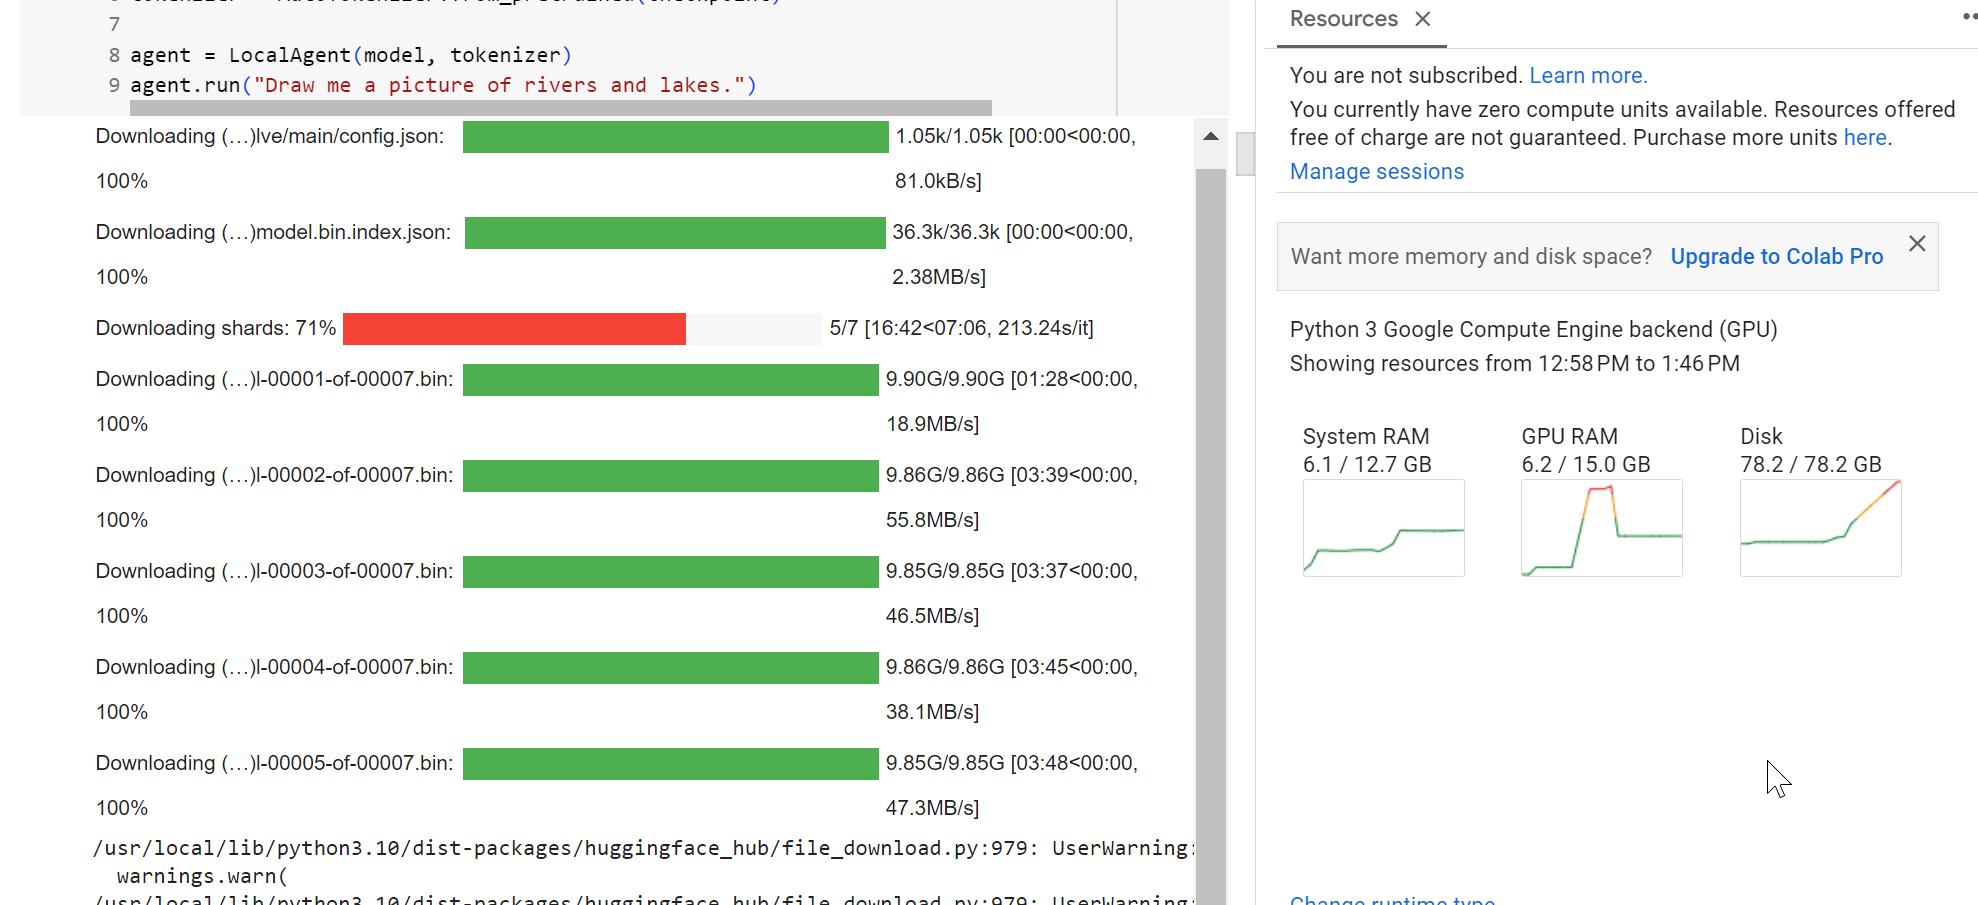

In [ ]:
from transformers import OpenAiAgent

agent = OpenAiAgent(model="text-davinci-003", api_key=xxx)
agent.run("Is the following `text` (in Spanish) positive or negative?", text="¡Este es un API muy agradable!")